# Introduction
This notebook proposes a model to predict the sale price of a house given descriptive features.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import norm

from sklearn.base import TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv, find_dotenv

# Data retrieval
Load training and test sets

In [2]:
def get_data_path():
    '''
    Return path to data depending on development environment (i.e. local machine or kaggle kernel)
    '''
    # Load environmental variables.
    load_dotenv(find_dotenv())
    if os.getenv('ENV') == 'local':
        return Path('../data')  # Local data
    else:
        return Path('/kaggle/input/house-prices-advanced-regression-techniques')  # Kaggle data


data_path = get_data_path()
train_df = pd.read_csv(data_path / 'train.csv', index_col=['Id'])
test_df = pd.read_csv(data_path / 'test.csv', index_col=['Id'])

In [3]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Exploration
Explore characteristics of the data.

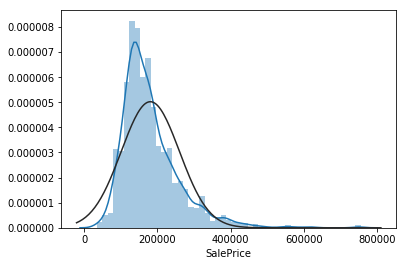

In [5]:
# Plot sale price histogram
sns.distplot(train_df.SalePrice, fit=norm);

SalePrice is quite skewed; transforming to log(SalePrice) should help.

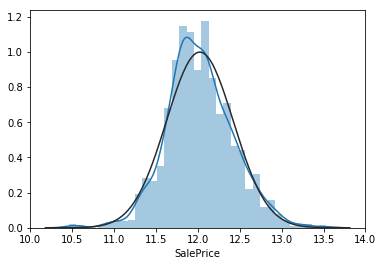

In [6]:
sns.distplot(np.log(train_df.SalePrice), fit=norm)

Thats better! Also this should help improve the scoring on the leaderboard which is evaluated using RMSE of the logged SalePrice.

Look at the distributions of 'Area' columns.

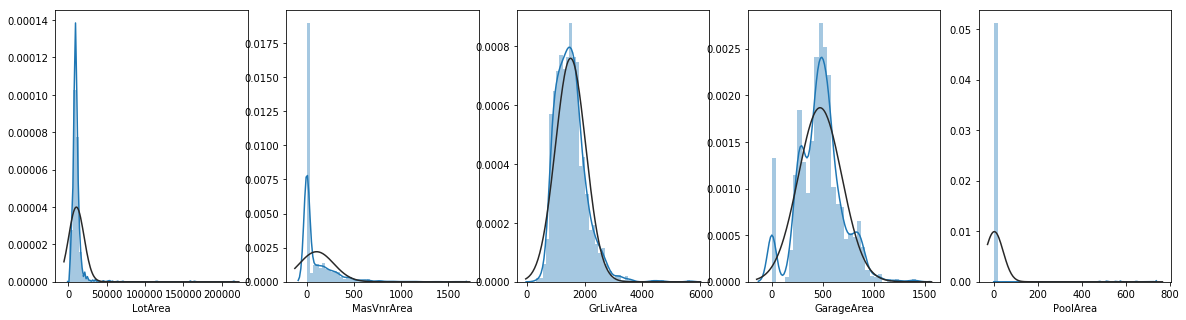

In [7]:
area_cols = [col for col in train_df if 'area' in col.lower()]
fig, ax = plt.subplots(1, len(area_cols), figsize=(20, 5)) 
for i, col in enumerate(area_cols):
    sns.distplot(train_df[col].dropna(), ax=ax[i], fit=norm)

Notes:
- MasVnrArea and PoolArea are zero-inflated.
- LotArea and MasVnrArea look quite skewed, while GrLivArea has a heavy-ish tail.

Look at the same columns logged (with zeros removed)

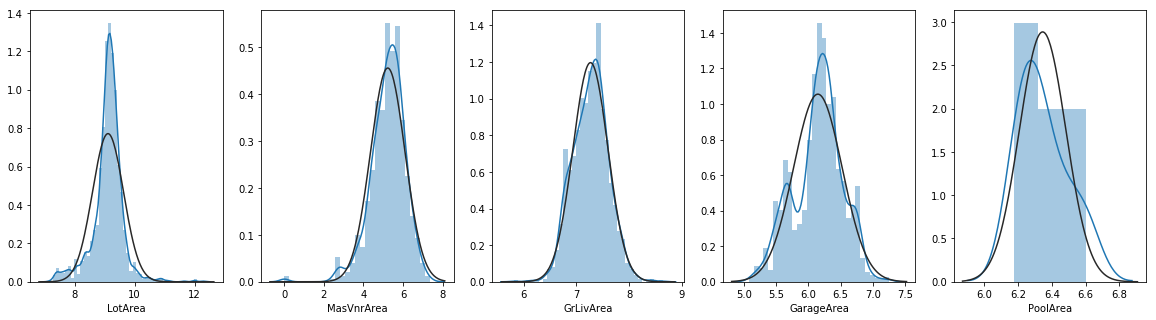

In [8]:
fig, ax = plt.subplots(1, len(area_cols), figsize=(20, 5)) 
for i, col in enumerate(area_cols):
    sns.distplot(np.log(train_df.loc[train_df[col] > 0, col]), ax=ax[i], fit=norm)

Most columns are looking closer to a normal distribution. The aim is:
- For the zero-inflated columns, add a label to indicate whether or not the value is zero.
- For every column apart from pool area, transform from linear to log where the value is non-zero.

Now we can do the same for the 'SF' columns.

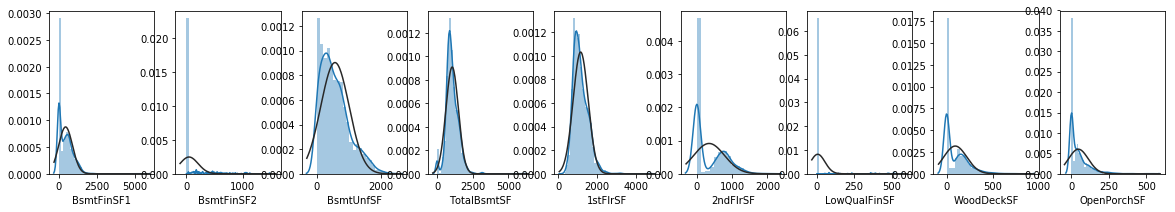

In [9]:
sf_cols = [col for col in train_df if 'sf' in col.lower()]
fig, ax = plt.subplots(1, len(sf_cols), figsize=(20, 3)) 
for i, col in enumerate(sf_cols):
    sns.distplot(train_df[col].dropna(), ax=ax[i], fit=norm)

Notes:
- Most of the SF cols have similar zero-inflation issues.
- Most are also skewed, so we can try to log and see if that helps.

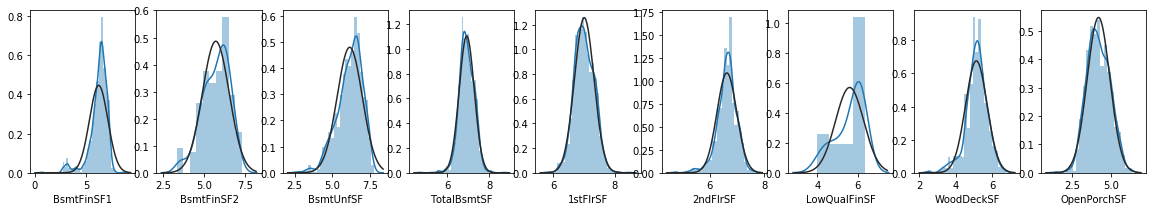

In [10]:
fig, ax = plt.subplots(1, len(sf_cols), figsize=(20, 3)) 
for i, col in enumerate(sf_cols):
    sns.distplot(np.log(train_df.loc[train_df[col] > 0, col]), ax=ax[i], fit=norm)

As above, in most cases the distributions look fairly normal after the log transform so we will aim to to the same as to the area columns in preprocessing below.

Now look into missing values.

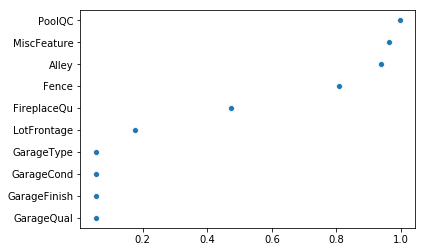

In [11]:
missing_fractions = train_df.isnull().sum() / len(train_df.index)

# Plot top 10 missing value columns.
top_missing = missing_fractions.sort_values().tail(10)
sns.scatterplot(top_missing.values, top_missing.index)

PoolQC, MiscFeature, Alley and Fence all have very high percentages (>80%) of null values. These columns will be removed during preprocessing, since the likelihood of reliably imputing them is small.

# Preprocessing
Implement preprocessing steps discussed in the exploration, and perform imputations/feature encoding.

In [12]:
# Log transform of SalePrice
train_df['LogSalePrice'] = np.log(train_df['SalePrice'])

In [13]:
# Drop columns with >80% of values missing. (include MiscVal since it is accociated with MiscFeature)
drop_cols = ['PoolQC', 'MiscFeature', 'MiscVal', 'Alley', 'Fence']
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

Fill missing values before transformations.

In [14]:
# Thanks very much to: https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
imputer = DataFrameImputer()
train_df = imputer.fit_transform(train_df)
test_df = imputer.transform(test_df)

In [15]:
def preprocess_area_columns(df):
    df = df.copy()
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df.drop(['PoolArea'], axis=1, inplace=True)  # Drop original column
    df['HasMasVnr'] = (df['MasVnrArea'] > 0).astype(int)
    df.drop(['MasVnrArea'], axis=1, inplace=True)  # Drop original column
    log_cols = ['LotArea', 'GrLivArea', 'GarageArea']
    df[log_cols] = np.where(df[log_cols] > 0, np.log(df[log_cols]), 0)
    return df

train_df = preprocess_area_columns(train_df)
test_df = preprocess_area_columns(test_df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [16]:
def preprocess_sf_columns(df):
    df = df.copy()
    df['HasBmst'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['Has2ndFlr'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasDeck'] = (df['WoodDeckSF'] > 0).astype(int)
    df['HasPorch'] = (df['OpenPorchSF'] > 0).astype(int)
    log_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF']
    df[log_cols] = np.where(df[log_cols] > 0, np.log(df[log_cols]), 0)
    return df

train_df = preprocess_sf_columns(train_df)
test_df = preprocess_sf_columns(test_df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Encode categorical features.

In [17]:
# Columns to be encoded
encode_cols = [col for col in train_df if train_df[col].dtype == np.dtype('O')]

# Train encoder on concatenated training and test sets.
encoder = OrdinalEncoder()
encoder.fit(pd.concat([train_df, test_df], sort=False)[encode_cols])

# Encode training and test sets
train_df[encode_cols] = encoder.transform(train_df[encode_cols])
test_df[encode_cols] = encoder.transform(test_df[encode_cols])
train_df[encode_cols].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,3.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,2.0,6.0,2.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,3.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,...,3.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,3.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
4,3.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,...,2.0,6.0,2.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
5,3.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0


In [18]:
feature_cols = [col for col in train_df if col not in ['SalePrice', 'LogSalePrice']]

X = train_df[feature_cols].values
y = train_df.LogSalePrice.values

X.shape

(1460, 78)

# Cross-validation
Cross validate model against competition scoring metric (RMSE of logged prediction vs logged true value).

In [19]:
# Used for leaderboard evaluation.
def root_mean_squared_error(*args):
    return mean_squared_error(*args) ** 0.5

# Scoring function for cross-validation.
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Grid search.
model = GradientBoostingRegressor(loss='ls', criterion='mse', random_state=0, subsample=0.9, max_depth=3)
param_grid = {
    'n_estimators': [550, 600, 650],
    'min_samples_split': [3, 4],
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, refit=True, n_jobs=-1)
grid_search.fit(X, y)

print(f'Best RMSE: {-grid_search.best_score_:.3f}')
print(f'Best estimator: {grid_search.best_estimator_}')

Best RMSE: 0.123
Best estimator: GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=600,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.9, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


Briefly look at feature importances.

In [20]:
feature_importances = grid_search.best_estimator_.feature_importances_
order = np.argsort(feature_importances)[::-1]  # Sort descending
for col, importance in zip(train_df.columns[order], feature_importances[order]):
    print(col, f'{importance:.5f}')

OverallQual 0.42735
GrLivArea 0.17211
TotalBsmtSF 0.05152
GarageCars 0.04745
YearBuilt 0.03108
GarageFinish 0.02546
YearRemodAdd 0.02430
BsmtFinSF1 0.02349
GarageArea 0.02278
LotArea 0.01817
CentralAir 0.01707
MSZoning 0.01661
OverallCond 0.01622
Fireplaces 0.01277
1stFlrSF 0.01211
KitchenQual 0.00813
SaleCondition 0.00557
2ndFlrSF 0.00536
GarageYrBlt 0.00456
BsmtFinType1 0.00400
BsmtUnfSF 0.00395
Neighborhood 0.00386
GarageType 0.00358
LotFrontage 0.00285
OpenPorchSF 0.00227
WoodDeckSF 0.00214
BsmtExposure 0.00206
BsmtFullBath 0.00205
Functional 0.00190
EnclosedPorch 0.00189
Condition1 0.00186
ExterQual 0.00176
MoSold 0.00167
BsmtQual 0.00164
Exterior1st 0.00152
ScreenPorch 0.00150
TotRmsAbvGrd 0.00140
HouseStyle 0.00118
HalfBath 0.00118
YrSold 0.00096
BedroomAbvGr 0.00094
Exterior2nd 0.00089
ExterCond 0.00084
HeatingQC 0.00080
Electrical 0.00071
SaleType 0.00063
FullBath 0.00061
LotConfig 0.00055
PavedDrive 0.00052
KitchenAbvGr 0.00051
BsmtFinSF2 0.00046
LotShape 0.00043
MasVnrType 0

The most important features by a long way are OverallQual and GrLivArea, which isn't surprising since it suggests that the nicer a house is and the bigger it is, the more expensive it is!

# Generate predictions
Generate predictions using best model and submit.

In [21]:
# Get best refitted estimator.
model = grid_search.best_estimator_

# Generate predictions.
X_test = test_df[feature_cols].values
log_y_pred = model.predict(X_test)

# Convert back to linear scale
y_pred = np.exp(log_y_pred)

Make submission dataframe and save to csv.

In [22]:
sample_sub_df = pd.read_csv(data_path / 'sample_submission.csv')

sub_df = pd.DataFrame({
    'Id': sample_sub_df['Id'].values.tolist(),
    'SalePrice': y_pred.ravel()
})

sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,Id,SalePrice
0,1461,122935.802549
1,1462,167795.085684
2,1463,185474.627466
3,1464,192463.953053
4,1465,179296.345117
